In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
titanic_train = pd.read_csv('titanic-train.csv')
titanic_test = pd.read_csv('titanic-test.csv')


In [3]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Separate categorical and numerical features for both datasets. 
Removed Name, Ticket, and Cabin, as the high amount of unique values of each column led to errors

In [14]:
numerical_features = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Sex', 'Embarked']

def process_data(df, is_training=True):
    df_processed = df.copy()

    X_num = df_processed[numerical_features].values
    X_cat = df_processed[categorical_features].values

    if is_training:
        y = df_processed['Survived'].values
        return X_num, X_cat, y
    else:
        return X_num, X_cat

X_num_train, X_cat_train, y_train = process_data(titanic_train, is_training=True)
X_num_test, X_cat_test = process_data(titanic_test, is_training=False)

print(f'Training Numerical Shape: {X_num_train.shape}')
print(f'Training Categorical Shape: {X_cat_train.shape}')
print(f'Training Target Shape: {y_train.shape}')
print(f'\nTest Numerical Shape: {X_num_test.shape}')
print(f'Test Categorical Shape: {X_cat_test.shape}')

Training Numerical Shape: (891, 6)
Training Categorical Shape: (891, 2)
Training Target Shape: (891,)

Test Numerical Shape: (418, 6)
Test Categorical Shape: (418, 2)


### Encode, HStack categorical and numerical features, scale, recheck shape

In [16]:
encoders = {}
X_cat_train_encoded = X_cat_train.copy()
X_cat_test_encoded = X_cat_test.copy()

for i in range(X_cat_train.shape[1]):
    encoders[i] = LabelEncoder()
    X_cat_train_encoded[:, i] = encoders[i].fit_transform(X_cat_train[:, i])
    X_cat_test_encoded[:, i] = encoders[i].transform(X_cat_test[:, i])

X_train_full = np.hstack((X_num_train, X_cat_train_encoded))
X_test_full = np.hstack((X_num_test, X_cat_test_encoded))

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_full)
X_test_imputed = imputer.transform(X_test_full)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print(f'Training Shape: {X_train_scaled.shape}')
print(f'Testing Shape: {X_test_scaled.shape}')

Training Shape: (891, 8)
Testing Shape: (418, 8)


### Perform PCA

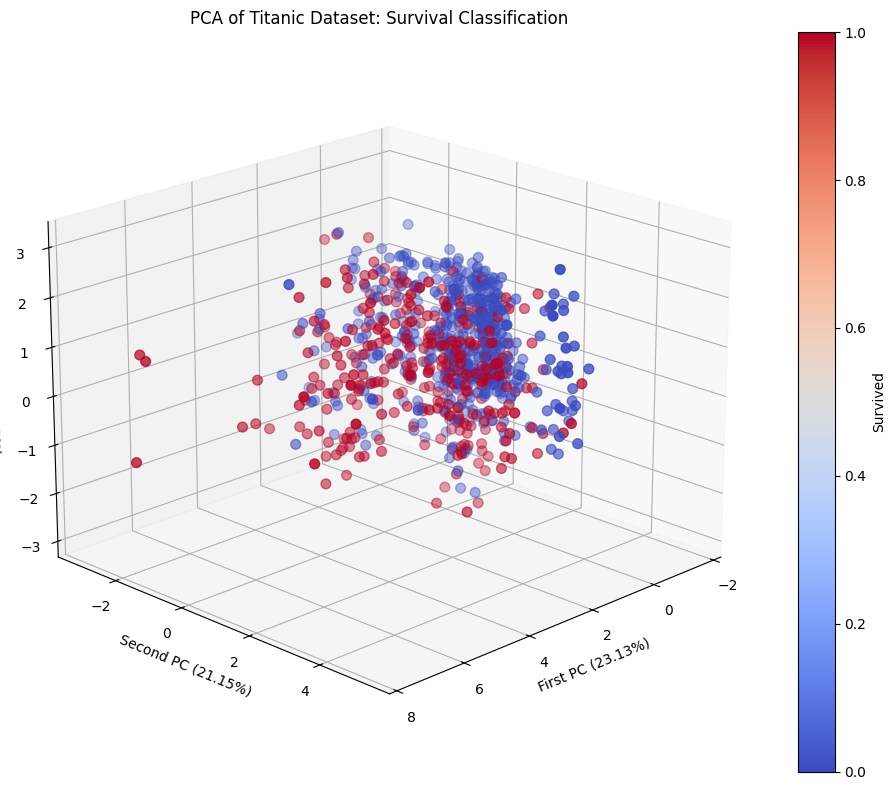

Explained variance ratio: [0.23129246 0.21515225 0.12823199]
Cumulative explained variance ratio: [0.23129246 0.44644471 0.5746767 ]


In [19]:
pca = PCA(n_components=3)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create new 3D visualization with adjusted parameters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Different way to create 3D axes

# Create scatter plot with explicit z parameter
scatter = ax.scatter(X_train_pca[:, 0], 
                    X_train_pca[:, 1], 
                    X_train_pca[:, 2],
                    c=y_train,
                    cmap=plt.cm.coolwarm,
                    s=50)  # Increased point size

# Set viewing angle
ax.view_init(elev=20, azim=45)  # Adjusted viewing angle

# Labels
ax.set_xlabel('First PC (23.13%)')
ax.set_ylabel('Second PC (21.15%)')
ax.set_zlabel('Third PC (12.82%)')

# Title and colorbar
plt.title('PCA of Titanic Dataset: Survival Classification')
plt.colorbar(scatter, label='Survived')

plt.tight_layout()
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))

### Implement SVC model

In [33]:
svc_model = SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svc_model = svc_model.fit(X_train_pca, y_train)

### Obtain predictions

In [51]:
predictions = svc_model.predict(X_test_pca)

### Export predictions to dataframe

In [67]:
test_predictions = pd.DataFrame({
    'PassengerId': titanic_test['PassengerId'],
    'Survived': predictions
})

print(f'\nFirst 25 predictions for example')
test_predictions.head(25)


First 25 predictions for example


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


### Display total prediction counts

In [69]:
print(f'\nPrediction Distribution:')
print(test_predictions['Survived'].value_counts())


Prediction Distribution:
Survived
0    334
1     84
Name: count, dtype: int64
